In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Constants:

In [22]:
L = 1000 # fiber length, m
Ladc = 1 # sampling frequency of receiver, m
alpha = 0.0410517 * 1e-3 # attenuation, 1/m
c = 300000000 # light speed, m/s
n0 = 1.5      # refractive index
lamda = 1550e-9 # wavelength, m
kv = 2*np.pi/lamda # wavenumber, 1/m  
w0 = kv * c # carrier frequency, Hz
n_metre = 1 # number rayleigh centres (RC) at 1 m

## 2. Graphical scalar model of fiber with random distrbution RC along Z-axis:
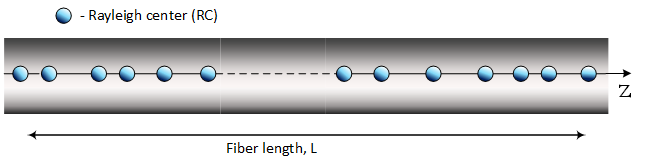

In [23]:
np.random.seed(1) # fixing random RC distribution
z_sc = np.sort(np.random.rand(int(n_metre*L)))*L # RC's coordinates along fiber

## 3 Backscattering signal graphical model:
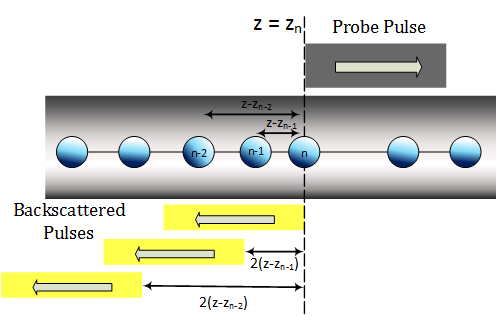

Sum of backscattered pulses at every RC:

$$A(z) = \sum_{n}^N H(2z-2z_n)\cdot e^{2ikz_n}$$  

In [28]:
Ndots = int(L / Ladc) 
A = np.zeros(Ndots, dtype='complex64') #A(z) backscattering signal (complex amplitude) at reciver (z=0, t=n*2*z_k/c)
time_back = 2 * L * n0 / c  # duration of backscattering signal, s
T = np.linspace(0, time_back, Ndots) # time-window of backscattered signal, s
Distance = T*c/n0/2 # spatial-window of backscattered signal, s
tau=200e-9
Timp = T[T <= tau]                        # time-window of probe pulse, s
H = np.heaviside(tau/2 - np.abs(Timp-tau/2),1) # probe pulse  

In [34]:
def trace(z_sc=z_sc):
    for z_n in z_sc:
        
        pulse_back = H * np.exp(2j * kv * z_n -  2 * z_n * alpha) # backscattered pulse at receiver (z=0)
        Zn = int(z_n / L * (Ndots) - len(Timp)) # it z-coordinate index in spatial-window "Distance" OTDR-trace

        if Zn < 0: 
            A[0:Zn+len(Timp)] += pulse_back[:Zn+len(Timp)]

        elif Zn >= 0: # in case when part pulse behind of spatial-window
            A[Zn:Zn+len(Timp)] += pulse_back[:]

        else: # in case when part pulse beyound of spatial-window
            A[Zn:Ndots] += pulse_back[:Ndots - Zn] 
    return A

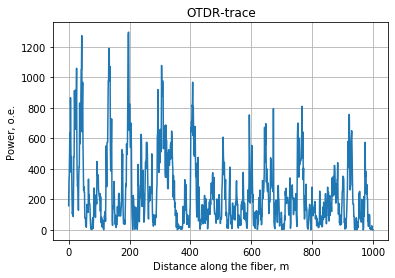

In [35]:
plt.plot(Distance, np.abs(trace())**2)
plt.title('OTDR-trace')
plt.ylabel('Power, o.e.')
plt.xlabel('Distance along the fiber, m')
plt.grid()

## 4. Simulation OTDR waterfall

### 4.1. Linear srain fiber over time
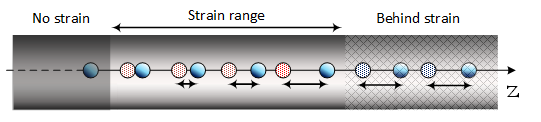

Text(775.0, 0.9, 'Behind strain')

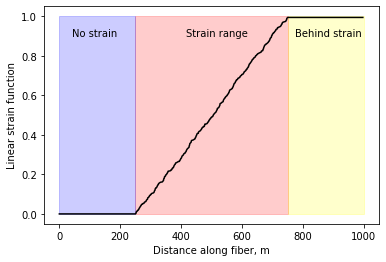

In [298]:
z_strain=L/4
range_strain=L/2
strain_func = np.cumsum(np.heaviside(range_strain/2 - np.abs(z_sc-z_strain-range_strain/2),1))/range_strain/n_metre
plt.plot(z_sc, strain_func, c='k')
plt.xlabel('Distance along fiber, m')
plt.ylabel('Linear strain function')

y=np.linspace(0,1,10)
x1=np.ones(10)*z_strain
x2=np.ones(10)*z_strain+range_strain
plt.fill_betweenx(y=y, x1=x1, x2=x2, color='r', alpha=0.2)
plt.annotate('Strain range', xy=(z_strain+range_strain/3, 0.9))

x1=np.zeros(10)
x2=np.ones(10)*z_strain
plt.fill_betweenx(y=y, x1=x1, x2=x2, color='b', alpha=0.2)
plt.annotate('No strain', xy=(z_strain/6, 0.9))

x1=np.ones(10)*z_strain+range_strain
x2=np.ones(10)*L
plt.fill_betweenx(y=y, x1=x1, x2=x2, color='yellow', alpha=0.2)
plt.annotate('Behind strain', xy=(z_strain+range_strain*1.05, 0.9))

### 4.2. Changing OTDR-trace due linear srain fiber over time

In [219]:
def trace_strain(z_sc, T, strain_func, strain):
    dz = 0
    A = np.zeros(Ndots, dtype='complex64') #A(z) backscattering signal (complex amplitude) at reciver (z=0, t=n*2*z_k/c)
    dz_sc = z_sc + strain_func * strain * T
    for z_n in dz_sc:
                
        pulse_back = H * np.exp(2j * (kv * z_n) -  2 * z_n * alpha) # backscattered pulse at receiver (z=0)
        Zn = int(z_n / L * (Ndots) - len(Timp)) # it z-coordinate index in spatial-window "Distance" OTDR-trace

        if Zn < 0: 
            A[0:Zn+len(Timp)] += pulse_back[:Zn+len(Timp)]

        elif Zn >= 0: # in case when part pulse behind of spatial-window
            A[Zn:Zn+len(Timp)] += pulse_back[:]

        else: # in case when part pulse beyound of spatial-window
            A[Zn:Ndots] += pulse_back[:Ndots - Zn] 
    return A

In [299]:
fp = 1000 # probing frequency, Hz
Longtime = 1 # time capturing data, s
Time = np.arange(0, Longtime, 1/fp)

z_strain=L/4
range_strain=L/2
strain_func = np.cumsum(np.heaviside(range_strain/2 - np.abs(z_sc-z_strain-range_strain/2),1))/range_strain/n_metre
strain = 1e-3 * range_strain / fp # milistrain per second

Waterfall = np.zeros((len(Time), len(Distance)), dtype=np.complex64)

In [221]:
for i, T in enumerate(Time):
    Waterfall[i,:] = trace_strain(z_sc=z_sc, T=T, strain_func=strain_func, strain=strain)

In [222]:
waterfall_intensity = np.abs(Waterfall)**2

Text(416.66666666666663, 75.33908203125, 'Strain range')

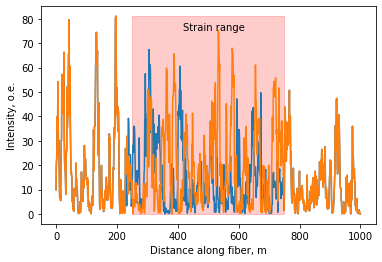

In [246]:
plt.plot(Distance, waterfall_intensity[0,:])
plt.plot(Distance, waterfall_intensity[-1,:])

plt.xlabel('Distance along fiber, m')
plt.ylabel('Intensity, o.e.')

y=np.linspace(0,np.max(waterfall_intensity[0]),10)
x1=np.ones(10)*z_strain
x2=np.ones(10)*z_strain+range_strain
plt.fill_betweenx(y=y, x1=x1, x2=x2, color='r', alpha=0.2)

plt.annotate('Strain range', xy=(z_strain+range_strain/3, 0.93*np.max(waterfall_intensity[0])))

Text(0.5, 1.0, 'OTDR waterfall')

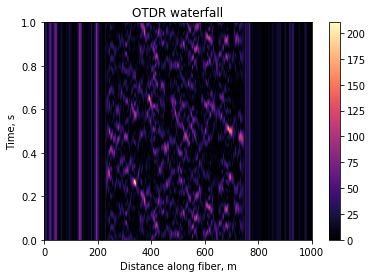

In [290]:
plt.imshow(waterfall_intensity, aspect='auto', origin='bottom', extent=[0, L, 0, Longtime], cmap='magma')
plt.colorbar()
plt.xlabel('Distance along fiber, m')
plt.ylabel('Time, s')
plt.title('OTDR waterfall')

### 4.3. Difference OTDR-traces

In [240]:
diff_waterfall = waterfall_intensity - waterfall_intensity[0]

Text(0, 0.5, 'Changing intensity, o.e.')

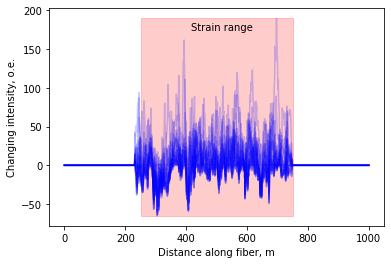

In [297]:
y=np.linspace(np.min(diff_waterfall[::50]), np.max(diff_waterfall[::50]),10)
x1=np.ones(10)*z_strain
x2=np.ones(10)*z_strain+range_strain
plt.fill_betweenx(y=y, x1=x1, x2=x2, color='r', alpha=0.2)

plt.plot(Distance, diff_waterfall[::50].T, alpha=0.2, color='b')


plt.annotate('Strain range', xy=(z_strain+range_strain/3, 0.9*np.max(waterfall_intensity[::50])))

plt.xlabel('Distance along fiber, m')
plt.ylabel('Changing intensity, o.e.')


Text(0.5, 1.0, 'OTDR difference waterfall')

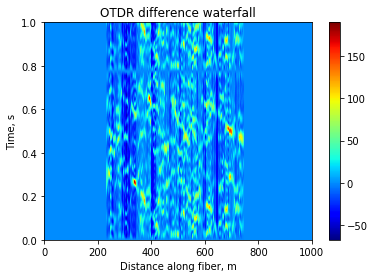

In [289]:
plt.imshow(diff_waterfall, aspect='auto', origin='bottom', extent=[0, L, 0, Longtime], cmap='jet')
plt.colorbar()
plt.xlabel('Distance along fiber, m')
plt.ylabel('Time, s')
plt.title('OTDR difference waterfall')